In [82]:
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import datetime

In [83]:
taxi = pd.read_csv('../data/train.csv')

In [84]:
taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Convert pickup and drop off to datetime

In [85]:
taxi.pickup_datetime = pd.to_datetime(taxi.pickup_datetime)
taxi.dropoff_datetime = pd.to_datetime(taxi.dropoff_datetime)

Choose only vendor 2 & month of January to create a subset from which we will take a sample to apply the model

In [86]:
subset = taxi[(taxi.vendor_id == 2) & (taxi.pickup_datetime.dt.month == 1)]

In [87]:
subset.shape

(124105, 11)

In [88]:
subset2 = subset.copy()

### Visualize the Data to Gain Insights

Also drop the rows with trip duration > 3h as outliers

In [89]:
subset2 = subset2[subset2.trip_duration < 10800]

Use a sample of 10k rows for clustering

In [90]:
df = subset2.sample(15000)

### Cleaning & data engineering for 2nd clustering

Drop store_and_fwd_flag & vendor_id columns as they are not significant for the clustering, and drop all latitude & longitude information as it's now represented by the cluster information

In [91]:
df_datetime = df.copy()

In [92]:
df_datetime.drop(['id','store_and_fwd_flag', 'vendor_id', 'pickup_longitude', 'pickup_latitude',
               'dropoff_longitude', 'dropoff_latitude'], inplace=True, axis=1)

Feature engineering on datetime: convert pick up and drop off dates to datetime

In [93]:
def get_data(dt):
    return [dt.day_name(), dt.hour]

df_datetime['pickup'] = df_datetime.pickup_datetime.map(get_data)
df_datetime['dropoff'] = df_datetime.pickup_datetime.map(get_data)

In [94]:
df_datetime.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_duration,pickup,dropoff
1020387,2016-01-16 16:41:37,2016-01-16 16:48:37,1,420,"[Saturday, 16]","[Saturday, 16]"
1003233,2016-01-06 11:03:06,2016-01-06 11:15:24,1,738,"[Wednesday, 11]","[Wednesday, 11]"
1381150,2016-01-11 04:52:30,2016-01-11 04:55:46,1,196,"[Monday, 4]","[Monday, 4]"
971935,2016-01-06 22:03:38,2016-01-06 22:20:33,1,1015,"[Wednesday, 22]","[Wednesday, 22]"
932714,2016-01-30 02:05:42,2016-01-30 02:23:26,2,1064,"[Saturday, 2]","[Saturday, 2]"


In [95]:
df_datetime.drop(['pickup_datetime', 'dropoff_datetime'], inplace=True, axis=1)

In [96]:
column_names = ['pickup_day', 'pickup_hour']

for i in range(len(column_names)):
    df_datetime[column_names[i]] = [x[i] for x in df_datetime['pickup']]

In [97]:
column_names = ['dropoff_day', 'dropoff_hour']

for i in range(len(column_names)):
    df_datetime[column_names[i]] = [x[i] for x in df_datetime['dropoff']]

In [98]:
df_datetime.drop(['pickup', 'dropoff'], inplace=True, axis=1)
df_datetime.head()

,passenger_count,trip_duration,pickup_day,pickup_hour,dropoff_day,dropoff_hour
1020387,1,420,Saturday,16,Saturday,16
1003233,1,738,Wednesday,11,Wednesday,11
1381150,1,196,Monday,4,Monday,4
971935,1,1015,Wednesday,22,Wednesday,22
932714,2,1064,Saturday,2,Saturday,2


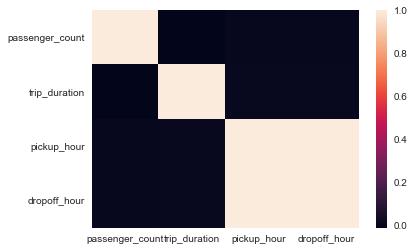

In [99]:
sns.heatmap(df_datetime.corr())

While pickup & drop off are highly correlated, as we're trying to cluster based on trip duration, we will keep this information. We will drop pick up & drop off datetime as we now have the month, hour & day columns

Plot trips by day

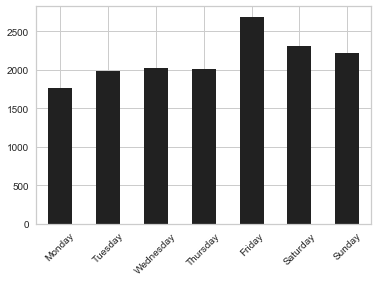

In [100]:
days_grouped = df_datetime.groupby(['pickup_day']).count().passenger_count.reset_index()
weekdays = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
mapping = {day: i for i, day in enumerate(weekdays)}
key = days_grouped['pickup_day'].map(mapping)    
days_grouped = days_grouped.iloc[key.argsort()]

ax = days_grouped.plot(kind='bar', x='pickup_day', legend = False, color=["#212121","#ffb700"])
ax.set_xticklabels(labels=weekdays, rotation=45)
ax.patch.set_facecolor('white')
plt.xlabel("")
plt.show()

Plot trips by hour

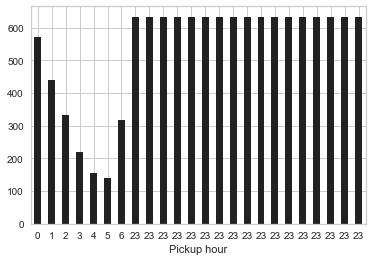

In [101]:
h_grouped = df_datetime.groupby(['pickup_hour']).count().passenger_count.reset_index()
hours = [0,1,2,3,4,5,6]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

ax = h_grouped.plot(kind='bar', x='pickup_hour', legend = False, color=["#212121","#ffb700"])
ax.xaxis.set_tick_params(rotation=0)
ax.patch.set_facecolor('white')
plt.xlabel("Pickup hour")
plt.show()

Plot pickup hours for working days vs weekend

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


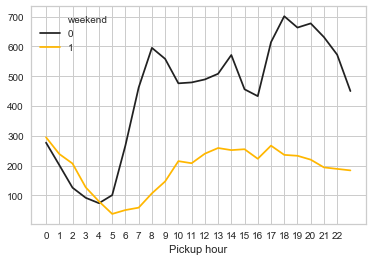

In [102]:
week_vs_wkd = df_datetime[['pickup_day', 'pickup_hour', 'passenger_count']]
week_vs_wkd['weekend'] = np.where(week_vs_wkd.pickup_day == 'Saturday', 1, 
                                  np.where(week_vs_wkd.pickup_day == 'Sunday', 1, 0))
h_grouped = week_vs_wkd.groupby(['weekend', 'pickup_hour']).count().passenger_count.reset_index()

hours = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
mapping = {hour: i for i, hour in enumerate(hours)}
key = h_grouped['pickup_hour'].map(mapping)    
h_grouped = h_grouped.iloc[key.argsort()]

colors = ["#212121","#ffb700"]
sns.set_palette(sns.color_palette(colors))
ax = sns.lineplot(x="pickup_hour", y="passenger_count", hue="weekend", data=h_grouped)
plt.xlabel("Pickup hour")
plt.ylabel("")
ax.patch.set_facecolor('white')
ax.set_xticks(range(0,23))
plt.show()

See if need to add weekend (y/n) column

In [22]:
# df_datetime['pickup_weekend_y/n'] = np.where(df_datetime.pickup_day == 'Saturday', 1, 
#                                   np.where(df_datetime.pickup_day == 'Sunday', 1, 0))
# df_datetime['dropoff_weekend_y/n'] = np.where(df_datetime.dropoff_day == 'Saturday', 1, 
#                                   np.where(df_datetime.dropoff_day == 'Sunday', 1, 0))

In [27]:
# Create labels of the day to put hours in 4 bins
# day_labels = ['night', 'morning', 'afternoon', 'evening']
# cutoffs = [-1, 5, 11, 17, 23]
# df_datetime['pickup_timeofday'] = pd.cut(df_datetime['pickup_hour'], cutoffs, labels=day_labels)
# df_datetime['dropoff_timeofday'] = pd.cut(df_datetime['dropoff_hour'], cutoffs, labels=day_labels)

In [28]:
#df_datetime.drop(['pickup_hour','dropoff_hour'], inplace=True, axis=1)

In [23]:
df_datetime.drop(['pickup_day','dropoff_day'], inplace=True, axis=1)

In [103]:
df_datetime.head()

,passenger_count,trip_duration,pickup_day,pickup_hour,dropoff_day,dropoff_hour
1020387,1,420,Saturday,16,Saturday,16
1003233,1,738,Wednesday,11,Wednesday,11
1381150,1,196,Monday,4,Monday,4
971935,1,1015,Wednesday,22,Wednesday,22
932714,2,1064,Saturday,2,Saturday,2


Do one hot encoding on day, time of day & neigbourhood fields to transform the categorical variable

In [104]:
df_dummies = pd.get_dummies(data=df_datetime, columns=['pickup_hour', 'dropoff_hour', 'pickup_day','dropoff_day'])

In [105]:
df_dummies = pd.get_dummies(data=df_dummies, columns=['passenger_count'])

In [106]:
df_dummies.head()

,trip_duration,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,...,dropoff_day_Thursday,dropoff_day_Tuesday,dropoff_day_Wednesday,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6
1020387,420,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1003233,738,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1381150,196,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
971935,1015,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
932714,1064,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### K-Means Clustering

Do further clustering for the new dataset to search for clusters based on pickup & dropoff time/day

Use elbow curve for cluster number

In [107]:
df_ML = df_dummies.copy()

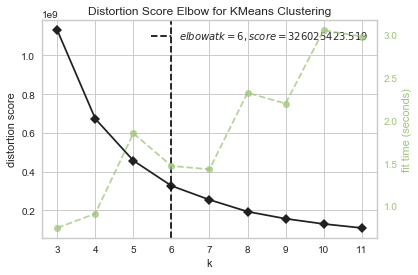

In [108]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,12), metric='distortion') #distortion=inertia
visualizer.fit(df_ML)
visualizer.poof()

In [109]:
kmeans = KMeans(n_clusters=6, random_state=8)
km1_clusters = kmeans.fit(df_ML)
labels_km1 = km1_clusters.predict(df_ML)

In [110]:
df_ML['clusters_km1'] =km1_clusters.labels_
df['clusters_km1'] =km1_clusters.labels_

In [111]:
from sklearn.metrics import silhouette_score 

X_cols = [col for col in df_ML.columns if col != 'clusters_km1']
X = df_ML[X_cols]

score_km1 = silhouette_score(X, labels_km1, metric='euclidean')
score_km1

0.545930547816134

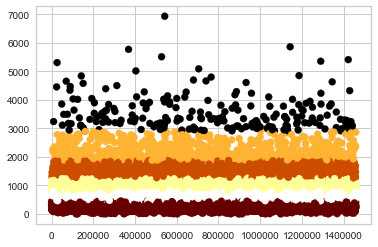

In [112]:
plt.scatter(df.index, df.trip_duration, c = df.clusters_km1, cmap=plt.get_cmap('afmhot')) 

Try plotting with pickup date vs drop off date

## Scale vs normalize

In [113]:
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 

scaler = StandardScaler() 
X_scaled = scaler.fit_transform(df_dummies) 
  
# Normalizing the data so that  
# the data approximately follows a Gaussian distribution 
#X_normalized = normalize(X_scaled) 
  
# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_scaled) 

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Apply PCA to reduce to 2 components

In [114]:
#Reducing the dimensionality of the data to make it visualizable
from sklearn.decomposition import PCA 

pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2']

### Apply k-means to PCA dataset

In [115]:
df_ML2 = X_principal.copy()

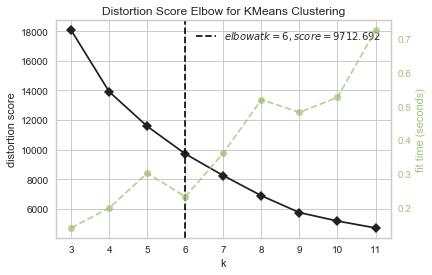

In [116]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,12), metric='distortion') #distortion=inertia
visualizer.fit(df_ML2)
visualizer.poof()

In [117]:
kmeans_km2 = KMeans(n_clusters=6)
km2_clusters = kmeans_km2.fit(df_ML2)
labels_km2 =km2_clusters.predict(df_ML2)

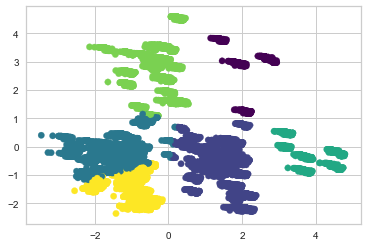

In [118]:
plt.scatter(df_ML2.P1 , df_ML2.P2, c=labels_km2, s=40, cmap='viridis') 

Visualizing the clustering with labels for clusters

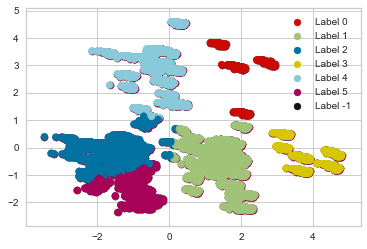

In [119]:
# Building the label to colour mapping 
colours = {} 
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
colours[3] = 'y'
colours[4] = 'c'
colours[5] = 'm'
  
# Building the colour vector for each data point 
cvec_km2 = [colours[label] for label in labels_km2] 
  
# For the construction of the legend of the plot 
r = plt.scatter(df_ML2['P1'], df_ML2['P2'], color ='r'); 
g = plt.scatter(df_ML2['P1'], df_ML2['P2'], color ='g'); 
b = plt.scatter(df_ML2['P1'], df_ML2['P2'], color ='b'); 
k = plt.scatter(df_ML2['P1'], df_ML2['P2'], color ='k'); 
y = plt.scatter(df_ML2['P1'], df_ML2['P2'], color ='y'); 
c = plt.scatter(df_ML2['P1'], df_ML2['P2'], color ='c'); 
m = plt.scatter(df_ML2['P1'], df_ML2['P2'], color ='m'); 

# Plotting P1 on the X-Axis and P2 on the Y-Axis  
# according to the colour vector defined 
# plt.figure(figsize =(9, 9)) 
plt.scatter(df_ML2['P1'], df_ML2['P2'], c = cvec_km2) 
  
# Building the legend 
plt.legend((r, g, b, y, c, m, k), ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label -1')) 
  
plt.show() 

In [120]:
df_ML2['clusters_km2'] = km2_clusters.labels_

In [121]:
score_km2 = silhouette_score(df_ML2[['P1', 'P2']], labels_km2, metric='euclidean')
score_km2

0.4522258395093216

In [122]:
df['clusters_km2'] = km2_clusters.labels_

### DBscan using PCA df

In [123]:
df_ML3 = X_principal.copy()

In [124]:
# Building the clustering model
from sklearn.cluster import DBSCAN 

db_clusters = DBSCAN(eps = 0.5, min_samples = 8).fit(df_ML3) 
labels_db = db_clusters.labels_

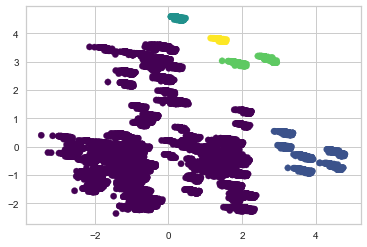

In [125]:
plt.scatter(df_ML3.P1 , df_ML3.P2, c=labels_db, s=40, cmap='viridis') 

In [126]:
df_ML3['clusters_db'] = db_clusters.labels_

In [127]:
score_db = silhouette_score(df_ML3[['P1', 'P2']], df_ML3['clusters_db'], metric='euclidean')
score_db

0.2860094120516697

### Gaussian Mixture using PCA df

In [128]:
df_ML4 = X_principal.copy()

In [133]:
from sklearn import mixture 
gmm = mixture.GaussianMixture(n_components=6).fit(df_ML4)
labels_gm = gmm.predict(df_ML4)

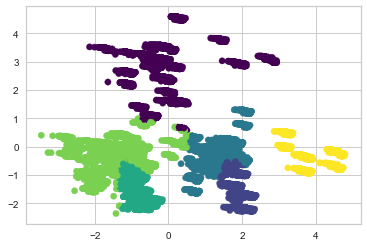

In [134]:
plt.scatter(df_ML4.P1 , df_ML4.P2, c=labels_gm, s=40, cmap='viridis')

In [135]:
df_ML4['clusters_gm'] = labels_gm

In [136]:
score_gm = silhouette_score(df_ML4, labels_gm, metric='euclidean')
score_gm

0.5321300394626891

In [137]:
df['clusters_gm'] = labels_gm

In [138]:
df_result = df.copy()

In [175]:
df_result['trip_duration_min'] = df_result.trip_duration/60

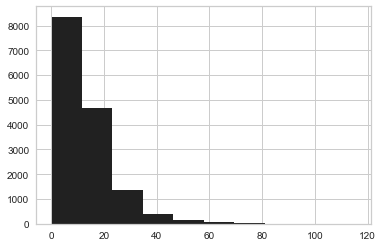

In [176]:
df_result['trip_duration_min'].hist()

In [177]:
# Create labels for trip duration
min_labels = ['<10min', '10-20min', '20-30min', '30-40min', '30-50min', '60-40min', '1-1,5h', '1,5-2h', '>2h']
cutoffs = [-1, 10, 20, 30, 40, 50, 60, 90, 120, 300]
df_result['duration_labels_min'] = pd.cut(df_result.trip_duration_min, cutoffs, labels=min_labels)

In [178]:
df_result.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,clusters_km1,clusters_km2,clusters_gm,trip_duration_h,duration_labels,trip_duration_min,duration_labels_min
1020387,id2585908,2,2016-01-16 16:41:37,2016-01-16 16:48:37,1,-73.970131,40.764992,-73.957108,40.778301,N,420,1,1,1,0.116667,<15min,7.000000,<10min
1003233,id1822250,2,2016-01-06 11:03:06,2016-01-06 11:15:24,1,-73.959633,40.764488,-73.978889,40.756088,N,738,5,2,4,0.205000,<15min,12.300000,10-20min
1381150,id2420564,2,2016-01-11 04:52:30,2016-01-11 04:55:46,1,-73.977524,40.764500,-73.993279,40.767849,N,196,1,1,2,0.054444,<15min,3.266667,<10min
971935,id1608648,2,2016-01-06 22:03:38,2016-01-06 22:20:33,1,-73.986694,40.758018,-73.972610,40.745056,N,1015,4,4,0,0.281944,15-30min,16.916667,10-20min
932714,id1653056,2,2016-01-30 02:05:42,2016-01-30 02:23:26,2,-73.993317,40.741341,-73.958717,40.815319,N,1064,4,3,5,0.295556,15-30min,17.733333,10-20min


In [179]:
df_group = df_result[['trip_duration_h', 'duration_labels_min', 'clusters_km2', 'clusters_gm']]

In [180]:
df_group[df_group.clusters_gm == 0]['duration_labels_min'].value_counts()

<10min      1386
10-20min    1071
20-30min     342
30-40min     124
30-50min      33
60-40min      24
1-1,5h        16
>2h            0
1,5-2h         0
Name: duration_labels_min, dtype: int64

There's no relation between the clusters and the trip duration or passenger count

In [182]:
df_datetime['clusters_km1'] =km1_clusters.labels_
df_datetime['clusters_km2'] = km2_clusters.labels_
df_datetime['clusters_db'] = db_clusters.labels_
df_datetime['clusters_gm'] = labels_gm

In [183]:
df_datetime.head()

,passenger_count,trip_duration,pickup_day,pickup_hour,dropoff_day,dropoff_hour,clusters_km1,clusters_km2,clusters_db,clusters_gm
1020387,1,420,Saturday,16,Saturday,16,1,1,0,1
1003233,1,738,Wednesday,11,Wednesday,11,5,2,0,4
1381150,1,196,Monday,4,Monday,4,1,1,0,2
971935,1,1015,Wednesday,22,Wednesday,22,4,4,0,0
932714,2,1064,Saturday,2,Saturday,2,4,3,1,5


In [152]:
df_datetime[df_datetime.clusters_db == 1]['pickup_hour'].value_counts()

0    295
1    239
2    207
3    127
4     80
Name: pickup_hour, dtype: int64

In [153]:
df_datetime[df_datetime.clusters_km2 == 3]['pickup_hour'].value_counts()

0    295
1    239
2    207
3    127
4     80
Name: pickup_hour, dtype: int64

In [155]:
df_datetime[df_datetime.clusters_km2 == 3]['pickup_day'].value_counts()

Sunday      487
Saturday    461
Name: pickup_day, dtype: int64

In [156]:
df_datetime[df_datetime.clusters_km2 == 0]['pickup_day'].value_counts()

Friday      351
Saturday    103
Name: pickup_day, dtype: int64

In [157]:
df_datetime[df_datetime.clusters_km2 == 1]['pickup_day'].value_counts()

Saturday     1716
Sunday       1714
Thursday      123
Wednesday     104
Tuesday       102
Monday         89
Name: pickup_day, dtype: int64

In [158]:
df_datetime[df_datetime.clusters_km2 == 2]['pickup_day'].value_counts()

Wednesday    1528
Tuesday      1079
Thursday     1064
Monday       1001
Saturday       29
Sunday         15
Name: pickup_day, dtype: int64

In [159]:
df_datetime[df_datetime.clusters_km2 == 2]['passenger_count'].value_counts()

1    3097
2     623
5     422
6     294
3     176
4     104
Name: passenger_count, dtype: int64

In [165]:
df_result[df_result.clusters_gm == 1]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,clusters_km1,clusters_km2,clusters_gm,trip_duration_h,duration_labels
1020387,id2585908,2,2016-01-16 16:41:37,2016-01-16 16:48:37,1,-73.970131,40.764992,-73.957108,40.778301,N,420,1,1,1,0.116667,<15min
340109,id3594205,2,2016-01-24 19:41:11,2016-01-24 19:52:26,2,-73.972603,40.758743,-73.954720,40.773254,N,675,5,1,1,0.187500,<15min
482624,id3740704,2,2016-01-10 12:50:03,2016-01-10 12:54:30,1,-74.001389,40.731113,-73.991516,40.744850,N,267,1,1,1,0.074167,<15min
1090806,id1946685,2,2016-01-10 19:18:57,2016-01-10 19:24:06,2,-73.973839,40.784710,-73.965477,40.800751,N,309,1,1,1,0.085833,<15min
219516,id0615059,2,2016-01-30 16:50:43,2016-01-30 17:14:13,1,-74.002563,40.744831,-74.000526,40.722149,N,1410,2,1,1,0.391667,15-30min
800116,id3590300,2,2016-01-30 18:18:35,2016-01-30 18:42:01,6,-73.986214,40.726189,-73.973953,40.778782,N,1406,2,1,1,0.390556,15-30min
1434271,id0989010,2,2016-01-10 17:03:47,2016-01-10 17:16:51,1,-73.984558,40.721802,-73.976753,40.752213,N,784,5,1,1,0.217778,<15min
1399842,id2949641,2,2016-01-10 18:51:43,2016-01-10 19:03:50,2,-73.994057,40.751217,-73.963043,40.757965,N,727,5,1,1,0.201944,<15min
867704,id2007174,2,2016-01-31 10:01:45,2016-01-31 10:24:59,1,-73.988548,40.748711,-73.789902,40.643169,N,1394,2,1,1,0.387222,15-30min
1090514,id0462508,2,2016-01-03 18:51:28,2016-01-03 19:10:26,1,-73.949669,40.784561,-74.002617,40.728359,N,1138,4,1,1,0.316111,15-30min


In [173]:
df_result[df_result.clusters_km1 == 1].duration_labels.value_counts()

<15min      4931
>2h            0
1,5-2h         0
1-1,5h         0
30-60min       0
15-30min       0
Name: duration_labels, dtype: int64

In [188]:
pd.crosstab(df_result.duration_labels_min,df_result.clusters_km1)

clusters_km1,0,1,2,3,4,5
duration_labels_min,,,,,,
<10min,0,4931,0,0,0,2204
10-20min,0,0,0,0,2745,2425
20-30min,0,0,1447,0,269,0
30-40min,0,0,119,479,0,0
30-50min,25,0,0,178,0,0
60-40min,105,0,0,0,0,0
"1-1,5h",68,0,0,0,0,0
"1,5-2h",5,0,0,0,0,0


In [192]:
df_result[df_result.clusters_km1 == 0].pickup_datetime.day().value_counts()

AttributeError: 'Series' object has no attribute 'day'

In [196]:
df_datetime.trip_duration_min = df_datetime.trip_duration/60

/Users/laumaustupa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [197]:
min_labels = ['<10min', '10-20min', '20-30min', '30-40min', '30-50min', '60-40min', '1-1,5h', '1,5-2h', '>2h']
cutoffs = [-1, 10, 20, 30, 40, 50, 60, 90, 120, 300]
df_datetime['duration_labels_min'] = pd.cut(df_datetime.trip_duration_min, cutoffs, labels=min_labels)

In [198]:
df_datetime.head()

,passenger_count,trip_duration,pickup_day,pickup_hour,dropoff_day,dropoff_hour,clusters_km1,clusters_km2,clusters_db,clusters_gm,duration_labels_min
1020387,1,420,Saturday,16,Saturday,16,1,1,0,1,<10min
1003233,1,738,Wednesday,11,Wednesday,11,5,2,0,4,10-20min
1381150,1,196,Monday,4,Monday,4,1,1,0,2,<10min
971935,1,1015,Wednesday,22,Wednesday,22,4,4,0,0,10-20min
932714,2,1064,Saturday,2,Saturday,2,4,3,1,5,10-20min


In [211]:
pd.crosstab(df_datetime.duration_labels_min,df_datetime.clusters_km2)

clusters_km2,0,1,2,3,4,5
duration_labels_min,,,,,,
<10min,237,2029,2169,452,1115,1133
10-20min,148,1275,1598,347,913,889
20-30min,52,379,570,119,288,308
30-40min,12,105,226,23,112,120
30-50min,4,40,88,4,28,39
60-40min,1,15,38,3,23,25
"1-1,5h",0,5,25,0,16,22
"1,5-2h",0,0,2,0,0,3


In [206]:
df_datetime[df_datetime.clusters_km1 == 4].trip_duration.min(), df_datetime[df_datetime.clusters_km1 == 4].trip_duration.max()

(811, 1262)

In [207]:
df_datetime[df_datetime.clusters_km1 == 3].trip_duration.min(), df_datetime[df_datetime.clusters_km1 == 3].trip_duration.max()

(1881, 2904)

In [208]:
df_datetime[df_datetime.clusters_km1 == 0].trip_duration.min(), df_datetime[df_datetime.clusters_km1 == 0].trip_duration.max()

(2911, 6934)

In [209]:
df_datetime[df_datetime.clusters_km1 == 1].trip_duration.min(), df_datetime[df_datetime.clusters_km1 == 1].trip_duration.max()

(3, 453)

In [203]:
df_datetime[df_datetime.clusters_km1 == 5].trip_duration.min(), df_datetime[df_datetime.clusters_km1 == 5].trip_duration.max()

(454, 810)

In [210]:
df_datetime[df_datetime.clusters_km1 == 2].trip_duration.min(), df_datetime[df_datetime.clusters_km1 == 2].trip_duration.max()

(1263, 1879)

### Hierarchical clustering

In [96]:
df_ML5 = df_dummies.copy()

In [97]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

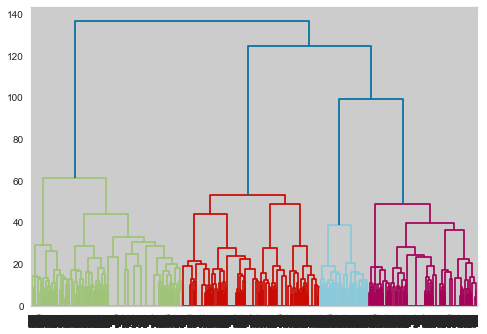

In [98]:
dendrogram = sch.dendrogram(sch.linkage(df_ML5, method='ward'))